##Purpose
- using DL to interpolate missing data from a data set

##How to deal
- remove the rows with missing data
- Selective removal - can still use the data vector
- replace missing data with the average of column data
- DL approach - predict the missing data. complete data is used as training data, missing data is the training dat

## This experiment
- import wine dataset
- choose 10 samples at random and replace residual sugar with NAN
- split into train and test
- train model and predict the missing values

- plot train/test loss & predictions vs observations

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for timing computations
import time
import copy


# for data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-1-f48e4c0946da>:25: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
# import the data
url  = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
# save a copy of the data (because we'll replace some values with nan's below)
dataOrig = copy.deepcopy( data )

In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,-0.786623
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,-0.786623
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,-0.786623
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,0.453492
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,-0.786623


In [4]:
# number of data points to set missing
n2nan = 10

# pick n random rows to set to nan
# (note: in the video I don't have replace=False, which means it's possible to select the same values twice)
whichVals2nan = np.random.choice(range(len(data)),size=n2nan,replace=False)

# set those values to be nan (safe to ignore the overwrite warning)
data['residual sugar'][whichVals2nan] = np.nan

# for splitting the data, it will be helpful to have a vector of all real-valued rows
whichValsNotNan = np.where(~data['residual sugar'].isna())[0]

# confirm
print(np.sort(whichVals2nan))
print(np.where(data['residual sugar'].isna())[0])

[  72  146  364  462  556 1038 1068 1218 1230 1439]
[  72  146  364  462  556 1038 1068 1216 1228 1437]


In [5]:
train_cols = data.keys().drop('residual sugar')



# train data is all the not nan rows
train_data = torch.tensor(data[train_cols].values).float()
train_dataT = train_data[whichValsNotNan,:]
train_labels = torch.tensor(data['residual sugar'].values).float()
train_labelsT = train_labels[whichValsNotNan,None]

# test data is all the nan rows
test_data = torch.tensor(dataOrig[train_cols].values).float()
test_dataT = train_data[whichVals2nan,:]
test_labels = torch.tensor(dataOrig['residual sugar'].values).float()
test_labelsT = test_labels[whichVals2nan,None]

print(f'Original data: {data.shape}\n')
print(f'   Train data: {train_dataT.shape}\n')
print(f' Train labels: {train_labelsT.shape}\n')
print(f'    Test data: {test_dataT.shape}\n')
print(f'  Test labels: {test_labelsT.shape}')

Original data: (1597, 12)

   Train data: torch.Size([1587, 11])

 Train labels: torch.Size([1587, 1])

    Test data: torch.Size([10, 11])

  Test labels: torch.Size([10, 1])


In [6]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) ) # fully connected
    x = F.sigmoid( self.fc2(x) )
    return self.output(x)

In [7]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel(train_loader):
  winenet = ANNwine()
  # loss function and optimizer
  lossfun = nn.MSELoss() #MSE is used for regression, nn.BCEWithLogitsLoss() is used for binary classification
  optimizer = torch.optim.Adam(winenet.parameters(),lr=.01)

  # initialize losses
  trainLoss = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    # winenet.train()

    # loop over training data batches
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

    trainLoss[epochi] = np.mean(batchLoss)

    # winenet.eval()
    # with torch.no_grad():
    #   yHat = winenet(test_data)
    # testLoss[epochi] = lossfun(yHat, test_labels).item()


  # function output
  return trainLoss, winenet

In [8]:
trainData_set = TensorDataset(train_dataT, train_labelsT)
batchsize=32
train_loader = DataLoader(trainData_set, batch_size=batchsize, shuffle=True, drop_last=True)

In [9]:
def plot_data(model, trainLoss):
  yHatTrain = model(train_dataT)
  yHatTest  = model(test_dataT)
  # plot some results
  fig,ax = plt.subplots(1,2,figsize=(16,5))

  ax[0].plot(trainLoss, label="Training Loss")
  ax[0].set_title('Train Loss')
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Loss")
  ax[0].legend()
  ax[0].grid()

  # show predictions and real values
  yHatTrain = model(train_dataT)
  yHatTest  = model(test_dataT)

  ax[1].plot(yHatTrain.detach(),train_labelsT,'ro')
  ax[1].plot(yHatTest.detach(),test_labelsT,'b^')
  ax[1].set_xlabel('Model-predicted sugar')
  ax[1].set_ylabel('True sugar')
  ax[1].set_title('Model predictions vs. observations')

  # correlations between predictions and outputs
  corrTrain = np.corrcoef(yHatTrain.detach().T,train_labelsT.T)[1,0]
  corrTest  = np.corrcoef(yHatTest.detach().T, test_labelsT.T)[1,0]
  ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

  plt.show()

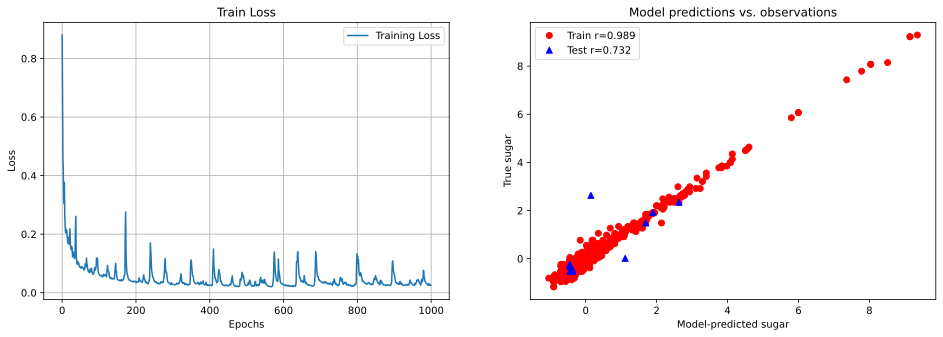

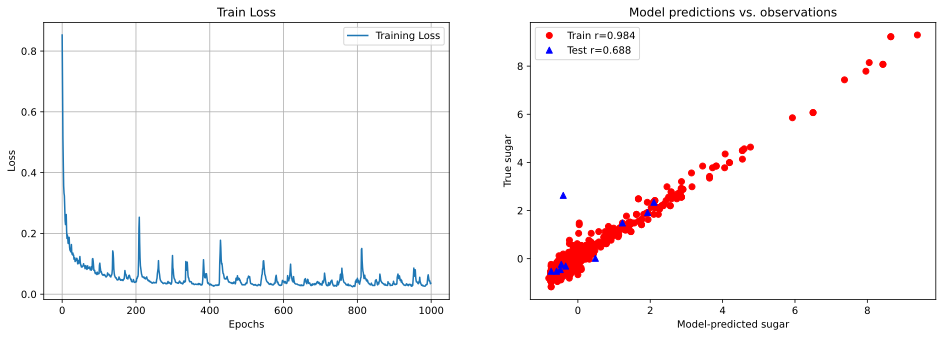

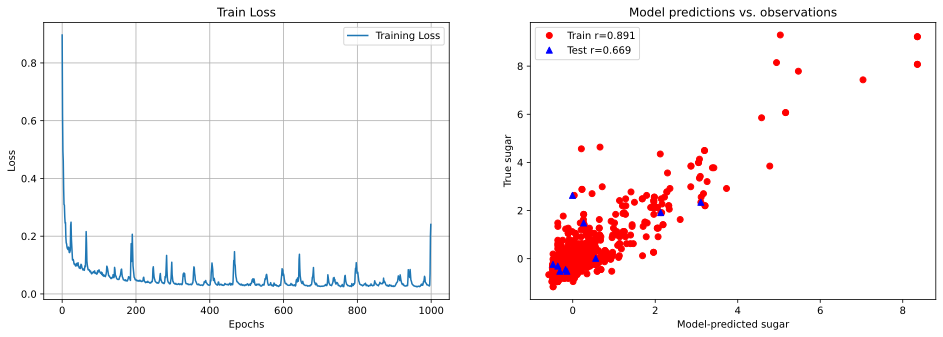

In [10]:
for i in range(3):
  trainLoss, model = trainTheModel(train_loader)
  plot_data(model, trainLoss)